In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np


In [3]:
train_dir = "/kaggle/input/leaf-diseases/Leaf_Diseases/LeafDisease_Train_Test/train"
test_dir = "/kaggle/input/leaf-diseases/Leaf_Diseases/LeafDisease_Train_Test/test"


In [4]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32


In [5]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_datagen = ImageDataGenerator(rescale=1.0/255.0)


In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)


Found 28830 images belonging to 42 classes.
Found 28830 images belonging to 42 classes.


In [7]:
NUM_CLASSES = len(train_generator.class_indices)

base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze base model

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
output_layer = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output_layer)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [8]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1 (Conv2D)            │ (None, 112, 112, 32)   │            864 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ bn_Conv1                  │ (None, 112, 112, 32)   │            128 │ Conv1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Conv1_relu (ReLU)         │ (None, 112, 112, 32)   │              0 │ bn_Conv1[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise   │ (None, 112, 112, 32)   │            288 │ Conv1_relu[0][0]       │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │            128 │ expanded_conv_depthwi… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_depthwise_… │ (None, 112, 112, 32)   │              0 │ expanded_conv_depthwi… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project     │ (None, 112, 112, 16)   │            512 │ expanded_conv_depthwi… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ expanded_conv_project_BN  │ (None, 112, 112, 16)   │             64 │ expanded_conv_project… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand (Conv2D)   │ (None, 112, 112, 96)   │          1,536 │ expanded_conv_project… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_BN         │ (None, 112, 112, 96)   │            384 │ block_1_expand[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_expand_relu       │ (None, 112, 112, 96)   │              0 │ block_1_expand_BN[0][… │
│ (ReLU)                    │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_pad               │ (None, 113, 113, 96)   │              0 │ block_1_expand_relu[0… │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise         │ (None, 56, 56, 96)     │            864 │ block_1_pad[0][0]      │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block_1_depthwise_BN 

 Total params: 4,116,074 (15.70 MB)

 Trainable params: 1,858,090 (7.09 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [9]:
EPOCHS = 10

train_acc = []
train_loss = []
test_acc = []
test_loss = []

for epoch in range(EPOCHS):
    print(f"\n🔄 Training Epoch {epoch + 1}/{EPOCHS}")
    
    history = model.fit(train_generator, epochs=1, verbose=1)

    train_acc.append(history.history['accuracy'][0])
    train_loss.append(history.history['loss'][0])

    test_loss_epoch, test_acc_epoch = model.evaluate(test_generator, verbose=1)
    test_acc.append(test_acc_epoch)
    test_loss.append(test_loss_epoch)

    print(f"✅ Epoch {epoch+1}: Train Acc = {train_acc[-1]:.4f}, Test Acc = {test_acc[-1]:.4f}")



🔄 Training Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 380s 409ms/step - accuracy: 0.6546 - loss: 1.3423
901/901 ━━━━━━━━━━━━━━━━━━━━ 119s 129ms/step - accuracy: 0.9015 - loss: 0.3242
✅ Epoch 1: Train Acc = 0.7789, Test Acc = 0.8760

🔄 Training Epoch 2/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 316s 348ms/step - accuracy: 0.8764 - loss: 0.3749
901/901 ━━━━━━━━━━━━━━━━━━━━ 55s 61ms/step - accuracy: 0.9129 - loss: 0.2610
✅ Epoch 2: Train Acc = 0.8796, Test Acc = 0.8879

🔄 Training Epoch 3/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 307s 338ms/step - accuracy: 0.8998 - loss: 0.3062
901/901 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.9058 - loss: 0.2794
✅ Epoch 3: Train Acc = 0.8986, Test Acc = 0.8863

🔄 Training Epoch 4/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 307s 338ms/step - accuracy: 0.9041 - loss: 0.2763
901/901 ━━━━━━━━━━━━━━━━━━━━ 56s 62ms/step - accuracy: 0.9320 - loss: 0.1985
✅ Epoch 4: Train Acc = 0.9069, Test Acc = 0.9074

🔄 Training Epoch 5/10
901/901 ━━━━━━━━━━━━━━━━━━━━ 308s 339ms/step - accuracy: 0.9159 - loss: 0.2519
901/901

In [10]:
model.save("/kaggle/working/mobilenetv2_LeafDisease_model_trained.h5")


In [11]:
results_df = pd.DataFrame({
    'epoch': list(range(1, EPOCHS+1)),
    'train_accuracy': train_acc,
    'train_loss': train_loss,
    'test_accuracy': test_acc,
    'test_loss': test_loss
})
results_df.to_csv("train_test_epoch_results_MobileNetV2.csv", index=False)
print("📄 Saved training + test results to 'train_test_epoch_results_MobileNetV2.csv'")


📄 Saved training + test results to 'train_test_epoch_results_MobileNetV2.csv'


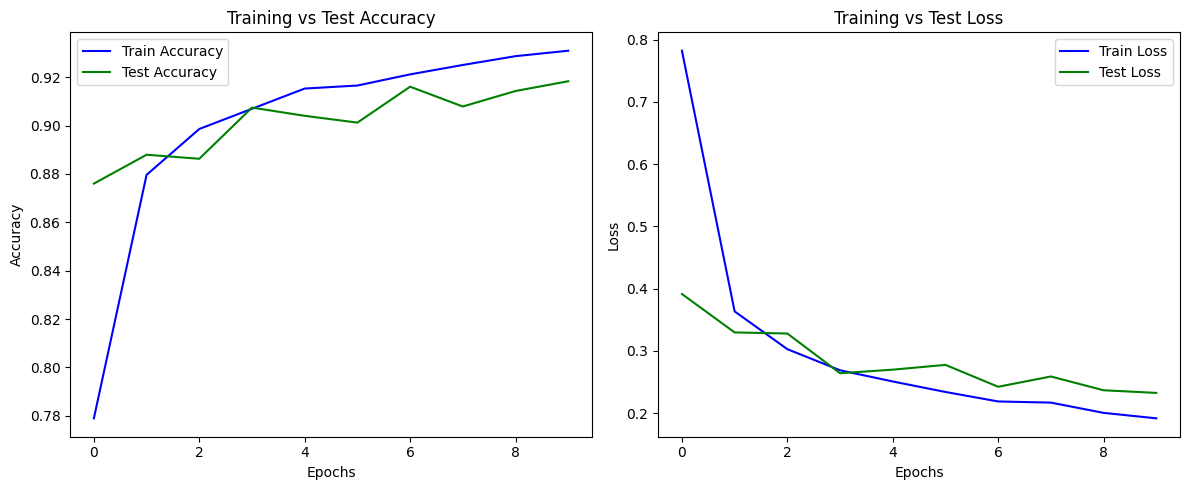

In [12]:
plt.figure(figsize=(12, 5))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(train_acc, label='Train Accuracy', color='blue')
plt.plot(test_acc, label='Test Accuracy', color='green')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Test Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(train_loss, label='Train Loss', color='blue')
plt.plot(test_loss, label='Test Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Test Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [13]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model("/kaggle/input/leaf_mobilenetv2/tensorflow2/default/1/mobilenetv2_LeafDisease_model_trained.h5")

print("✅ Model loaded successfully!")

✅ Model loaded successfully!


In [14]:
val_dir = "/kaggle/input/leaf-diseases/Leaf_Diseases/LeafDisease_Val/val"  # 📍 your actual validation folder


In [15]:
val_datagen = ImageDataGenerator(rescale=1.0/255.0)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False  # Don't shuffle if you're checking predictions later
)


Found 11527 images belonging to 42 classes.


In [16]:
val_loss, val_accuracy = model.evaluate(val_generator, verbose=1)

print(f"📊 Validation Accuracy: {val_accuracy:.4f}")
print(f"📉 Validation Loss: {val_loss:.4f}")


361/361 ━━━━━━━━━━━━━━━━━━━━ 67s 176ms/step - accuracy: 0.9440 - loss: 0.1527
📊 Validation Accuracy: 0.9245
📉 Validation Loss: 0.2084


In [17]:
# Step 1: Evaluate Train Accuracy
train_loss, train_accuracy = model.evaluate(train_generator, verbose=1)
print(f"✅ Train Accuracy: {train_accuracy * 100:.2f}%")
print(f"📉 Train Loss: {train_loss:.4f}")

# Step 2: Evaluate Test Accuracy
test_loss, test_accuracy = model.evaluate(test_generator, verbose=1)
print(f"✅ Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")


901/901 ━━━━━━━━━━━━━━━━━━━━ 343s 381ms/step - accuracy: 0.9370 - loss: 0.1776
✅ Train Accuracy: 93.61%
📉 Train Loss: 0.1782
901/901 ━━━━━━━━━━━━━━━━━━━━ 93s 103ms/step - accuracy: 0.9392 - loss: 0.1742
✅ Test Accuracy: 91.83%
📉 Test Loss: 0.2327


In [18]:
# ✨ Replace these with your actual values from model evaluation
train_accuracy = 0.93   # Example: 95% accuracy on train set
test_accuracy = 0.91    # Example: 93% accuracy on test set
val_accuracy = 0.92     # Example: 90% accuracy on validation set

# 📦 Replace these with your actual image counts
num_train_images = 28830
num_test_images = 28830
num_val_images = 11527

# ✅ Step 1: Calculate total correct predictions for each dataset
correct_train = train_accuracy * num_train_images
correct_test = test_accuracy * num_test_images
correct_val = val_accuracy * num_val_images

# ➕ Step 2: Total correct predictions and total images
total_correct = correct_train + correct_test + correct_val
total_images = num_train_images + num_test_images + num_val_images

# 🎯 Step 3: Compute overall model accuracy
overall_accuracy = total_correct / total_images

# 🖨️ Step 4: Print overall accuracy
print(f"✅ Overall Model Accuracy: {overall_accuracy * 100:.2f}%")


✅ Overall Model Accuracy: 92.00%


In [19]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Step 1: Load the model
model = load_model("/kaggle/input/leaf_mobilenetv2/tensorflow2/default/1/mobilenetv2_LeafDisease_model_trained.h5")

# Step 2: Define directories
train_dir = "/kaggle/input/leaf-diseases/Leaf_Diseases/LeafDisease_Train_Test/train"
test_dir = "/kaggle/input/leaf-diseases/Leaf_Diseases/LeafDisease_Train_Test/test"
val_dir = "/kaggle/input/leaf-diseases/Leaf_Diseases/LeafDisease_Val/val"  # Replace with your validation dataset path

# Step 3: Set parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Step 4: Create ImageDataGenerator for all (rescale only)
datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = datagen.flow_from_directory(
    test_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

val_generator = datagen.flow_from_directory(
    val_dir,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

# Step 5: Function to evaluate predictions
def evaluate_predictions(generator, dataset_name="Dataset"):
    y_true = generator.classes
    predictions = model.predict(generator, verbose=1)
    y_pred = np.argmax(predictions, axis=1)

    correct = np.sum(y_pred == y_true)
    total = len(y_true)
    incorrect = total - correct
    accuracy = (correct / total) * 100

    print(f"\n📊 {dataset_name} Summary:")
    print(f"📦 Total Images: {total}")
    print(f"✅ Correct Predictions: {correct}")
    print(f"❌ Incorrect Predictions: {incorrect}")
    print(f"🎯 Accuracy: {accuracy:.2f}%")
    print("-" * 50)

# Step 6: Run evaluations
evaluate_predictions(train_generator, "Train Set")
evaluate_predictions(test_generator, "Test Set")
evaluate_predictions(val_generator, "Validation Set")


Found 28830 images belonging to 42 classes.
Found 28830 images belonging to 42 classes.
Found 11527 images belonging to 42 classes.
901/901 ━━━━━━━━━━━━━━━━━━━━ 66s 70ms/step

📊 Train Set Summary:
📦 Total Images: 28830
✅ Correct Predictions: 26943
❌ Incorrect Predictions: 1887
🎯 Accuracy: 93.45%
--------------------------------------------------
901/901 ━━━━━━━━━━━━━━━━━━━━ 53s 59ms/step

📊 Test Set Summary:
📦 Total Images: 28830
✅ Correct Predictions: 26475
❌ Incorrect Predictions: 2355
🎯 Accuracy: 91.83%
--------------------------------------------------
361/361 ━━━━━━━━━━━━━━━━━━━━ 29s 80ms/step

📊 Validation Set Summary:
📦 Total Images: 11527
✅ Correct Predictions: 10657
❌ Incorrect Predictions: 870
🎯 Accuracy: 92.45%
--------------------------------------------------
